In [251]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import lightkurve as lk
plt.rcParams.update({'font.size': 18})
plt.style.use('vedant')
import sys
sys.path.append('../../WD_models/')
from sed_fitter import FitSED
from tqdm import tqdm
from scipy import stats

In [252]:
import P4J
#import recombinator
import astropy.units as u
import pandas as pd

In [253]:
def get_mean_flux(t, flux, e_flux, gap = 10, plot = False):
        
    sortidx = np.argsort(t)
    t = t[sortidx]
    flux = flux[sortidx]
    e_flux = e_flux[sortidx]
    
    e_flux[np.isnan(e_flux)] = np.nanmax(e_flux)
    
    fi = np.where(abs(np.diff(t)) > gap)[0]

    fi = np.concatenate(([-1], fi))

    sm_pt = 0

    mean_times = [];
    mean_flux = [];
    e_mean_flux = [];

    flux_arr = [];
    e_flux_arr = [];
    t_arr = [];
    for kk in range(len(fi)):

        idx1 = fi[kk] + 1
        if kk < len(fi)-1:
            idx2 = fi[kk + 1] + 1
        elif kk == len(fi)-1:
            idx2 = None

        t_i = t[idx1:idx2]
        flux_i = flux[idx1:idx2]
        e_flux_i = e_flux[idx1:idx2]

        sm_pt += len(t_i)
        
        if plot:

            plt.figure()
            plt.plot(t_i, flux_i, 'ko')
            plt.show()

        t_arr.append(t_i)
        flux_arr.append(flux_i)

        mean_times.append(np.mean(t_i))
        mean_flux.append(np.average(flux_i, weights = (1 / e_flux_i)**2))
        e_mean_flux.append(np.median(e_flux_i) / np.sqrt(len(t_i)) + stats.sem(flux_i))

    meanlc = lk.LightCurve(time = mean_times, flux = mean_flux, flux_err = e_mean_flux)
    
    return meanlc

# WISE Light Curve

In [254]:
allwise = pd.read_csv('wise_data/d62_allwise.csv')
neowiseR = pd.read_csv('wise_data/d62_neowise_R.csv')

neo_clean = (
    (neowiseR['ra'] > 324.6117)&
    (neowiseR['ra'] < 324.6133)&
    (neowiseR['w1sigmpro'] < 0.3)&
    (neowiseR['w1rchi2'] < 1.5)&
    (neowiseR['w1snr'] > 3)&
    (neowiseR['w1sigmpro'] > 0)

)

print(len(allwise))

print(len(neowiseR))
print(len(neowiseR[neo_clean]))

neowiseR = neowiseR[neo_clean]

27
178
141


In [255]:
allwise_mjd = np.array(allwise['mjd'])
allwise_mags = np.array(allwise['w1mpro_ep'])
e_allwise_mags = np.array(allwise['w1sigmpro_ep'])
allwise_mags2 = np.array(allwise['w2mpro_ep'])
e_allwise_mags2 = np.array(allwise['w2sigmpro_ep'])

neowiseR_mjd = np.array(neowiseR['mjd'])
neowiseR_mags = np.array(neowiseR['w1mpro'])
e_neowiseR_mags = np.array(neowiseR['w1sigmpro'])
neowiseR_mags2 = np.array(neowiseR['w2mpro'])
e_neowiseR_mags2 = np.array(neowiseR['w2sigmpro'])

mjd = np.concatenate((allwise_mjd, neowiseR_mjd))

mags = np.concatenate((allwise_mags, neowiseR_mags))
e_mags = np.concatenate((e_allwise_mags, e_neowiseR_mags))

mags2 = np.concatenate((allwise_mags2, neowiseR_mags2))
e_mags2 = np.concatenate((e_allwise_mags2, e_neowiseR_mags2))
e_mags2[np.isnan(e_mags2)] = np.nanmax(e_mags2)

In [256]:
len(mags)

168

In [257]:
lc1_raw = lk.LightCurve(mjd, mags, e_mags)
lc2_raw = lk.LightCurve(mjd, mags2, e_mags2)

lc1 = get_mean_flux(mjd, mags, e_mags, gap = 10);
lc2 = get_mean_flux(mjd, mags2, e_mags2, gap = 10);

mean_times = lc1.time

/Users/vedantchandra/opt/anaconda3/envs/d62/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


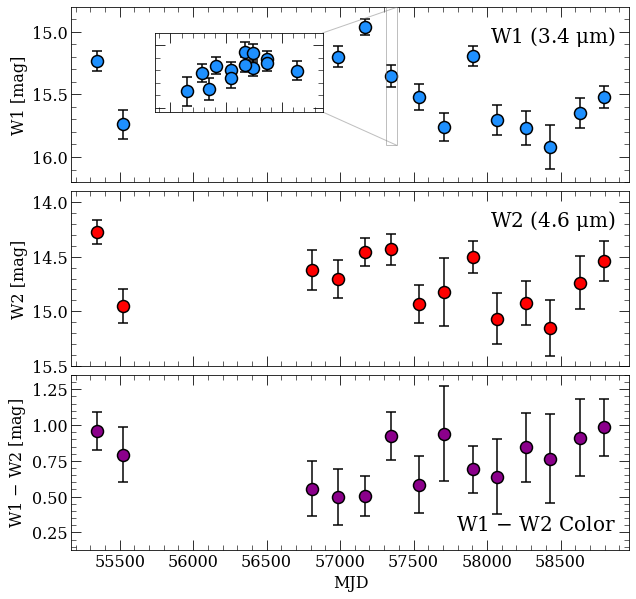

In [263]:
plt.figure(figsize = (10, 10))

plt.subplot(311)

kwargs = dict(linestyle = 'none', marker = 'o', ecolor = 'k', color = 'dodgerblue', capsize = 5, linewidth = 1.5,
             mec = 'k', mew = 1.5, markersize = 12)

plt.errorbar(lc1.time.value, lc1.flux.value, yerr = lc1.flux_err.value, **kwargs)
plt.text(0.975, 0.9, 'W1 (3.4 $\mu$m)', ha = 'right', va = 'top', transform = plt.gca().transAxes, fontsize = 20)
plt.gca().set_xticklabels([])
plt.ylabel('W1 [mag]')
plt.ylim(14.8, 16.2)
plt.gca().invert_yaxis()

ax = plt.gca()
axins = ax.inset_axes([0.15, 0.4, 0.3, 0.45])
axins.errorbar(mjd, mags, yerr = e_mags, **kwargs)
# sub region of the original image
jj = 5
dm = 0.55
x1, x2, y1, y2 = lc1.time[jj].value - 35, lc1.time[jj].value + 35, lc1.flux[jj].value - dm, lc1.flux[jj].value + dm
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins)
axins.set_ylim(lc1.flux[jj].value - dm, lc1.flux[jj].value + 1.3*dm)
axins.set_xlim(lc1.time[jj].value - .5, lc1.time[jj].value + 1)
axins.invert_yaxis()


plt.subplot(312)

kwargs = dict(linestyle = 'none', marker = 'o', ecolor = 'k', color = 'red', capsize = 5, linewidth = 1.5,
             mec = 'k', mew = 1.5, markersize = 12)

plt.errorbar(lc2.time.value, lc2.flux.value, yerr = lc2.flux_err.value, **kwargs)
plt.gca().set_xticklabels([])
plt.ylabel('W2 [mag]')
plt.text(0.975, 0.9, 'W2 (4.6 $\mu$m)', ha = 'right', va = 'top', transform = plt.gca().transAxes, fontsize = 20)
plt.ylim(13.9, 15.5)
plt.gca().invert_yaxis()

plt.subplot(313)


kwargs = dict(linestyle = 'none', marker = 'o', ecolor = 'k', color = 'darkmagenta', 
              capsize = 5, linewidth = 1.5,
             mec = 'k', mew = 1.5, markersize = 12)

ratio = lc1.flux.value - lc2.flux.value
error = np.sqrt(lc1.flux_err.value**2 + lc2.flux_err.value**2)#ratio * np.sqrt((e_mean_fls / mean_fls)**2 + (e_mean_fls2/mean_fls2)**2)
plt.errorbar(lc2.time.value, ratio, yerr = error,**kwargs)
plt.text(0.975, 0.2, 'W1 $-$ W2 Color', ha = 'right', va = 'top', transform = plt.gca().transAxes, fontsize = 20)
plt.ylim(0.125, 1.35)

plt.xlabel('MJD')
plt.ylabel('W1 $-$ W2 [mag]')
plt.subplots_adjust(hspace = 0.05)

plt.savefig('fig/jwst_lc.pdf', bbox_inches = 'tight')

In [268]:
fitsed = FitSED(bands = ['W1'])
fitsed2 = FitSED(bands = ['W2'])

initialized with atm_type = H and bands = ['W1']
initialized with atm_type = H and bands = ['W2']


### Temperature Variation

In [381]:
stellar_model =  np.loadtxt('txt/stellar_model.txt')
wls = np.loadtxt('txt/wls.txt')

mjd = lc1.time.value

flux1 = np.array([fitsed.mag_to_flux([lc1.flux.value[ii]]) for ii in range(len(lc1.flux))]).ravel()

flux1 -= stellar_model[-2]

e_flux1 = lc1.flux_err.value * flux1

flux2 = np.array([fitsed.mag_to_flux([lc2.flux.value[ii]]) for ii in range(len(lc2.flux))]).ravel()

flux2 -= stellar_model[-1]

e_flux2 = lc2.flux_err.value * flux2

In [382]:
def bb_model(wl, T, R):
    
    R = R * c.R_sun
    D = (1000 / bestfit[2]) * c.pc
    
    nu = c.c / (wl * 1e-10 * u.m)
    
    sa = np.pi * R**2 / D**2
    
    t1 = 2 * c.h * nu**3 / c.c**2
    t2 = np.exp(c.h * nu / (c.k_B * T * u.K)) - 1
    
    return (sa * t1 / t2).to(u.Jy).value

In [383]:
p0 = [1000, 14]

100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


Text(0, 0.5, 'Flux')

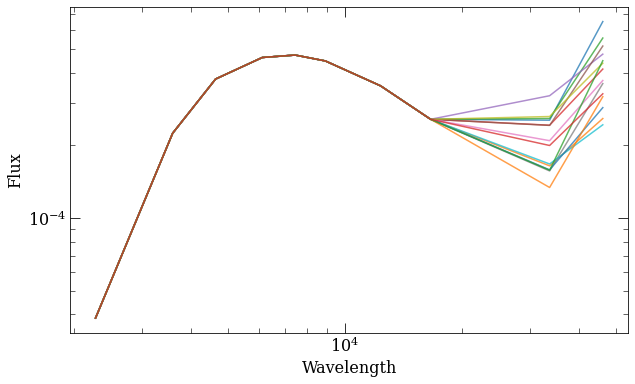

In [399]:
T = [];
e_T = [];

R = [];
e_R = [];

nmc = 25

plt.figure(figsize = (10, 6))

for ii in tqdm(range(len(flux1))):
    Ti = [];
    Ri = [];
    for n in range(nmc):
        
        
        sed = np.array([flux1[ii], flux2[ii]])
        sed += np.array([e_flux1[ii] * np.random.normal(), e_flux2[ii] * np.random.normal()])
        
        sed = np.concatenate((np.repeat(0, len(stellar_model) - 2), sed)) # add star fluxes
        
        if n == 0:
            plt.plot(wls, stellar_model + sed, lw = 1.5, alpha = 0.75)
        
        #plt.plot(wls, sed)
        #break
        
        p,cov = scipy.optimize.curve_fit(bb_model, wls, sed, p0 = p0)
        
        Ti.append(p[0])
        Ri.append(p[1])
        
    T.append(np.mean(Ti))
    e_T.append(np.std(Ti))
    
    R.append(np.mean(Ri))
    e_R.append(np.std(Ri))
    
T = np.array(T)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Wavelength')
plt.ylabel('Flux')

Text(0, 0.5, 'BB Norm Radius (K)')

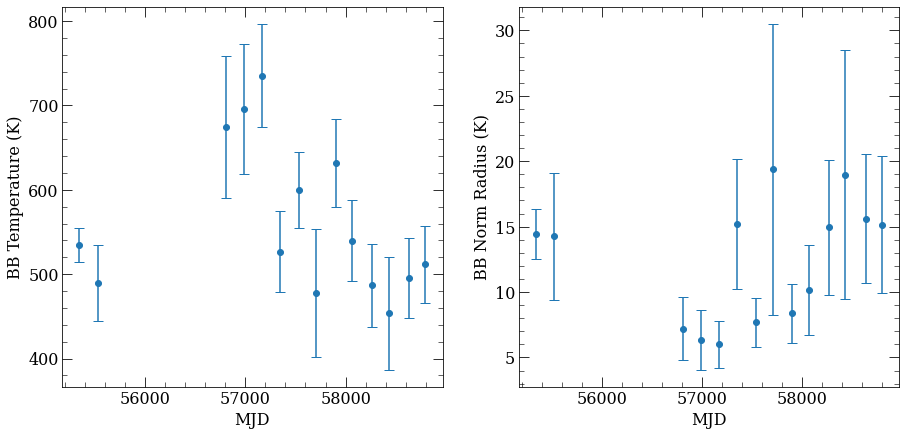

In [400]:
plt.figure(figsize = (15, 7))

kw = dict(linestyle = 'none', marker = 'o', capsize = 5)

plt.subplot(121)
plt.errorbar(mjd, T, yerr = e_T, **kw)
plt.xlabel('MJD')
plt.ylabel('BB Temperature (K)')

plt.subplot(122)
plt.errorbar(mjd, R, yerr = e_R, **kw)

plt.xlabel('MJD')
plt.ylabel('BB Norm Radius (K)')

In [404]:
def Rin_bb(Tin, Rstar, Tstar):
    return (Rstar / 2) * (Tstar / Tin)**(2)

def Rin_rayl(Tin, Rstar, Tstar):
    return (Rstar / 2) * (Tstar / Tin)**(5/2)

0.44856312121143094
0.53962401970517


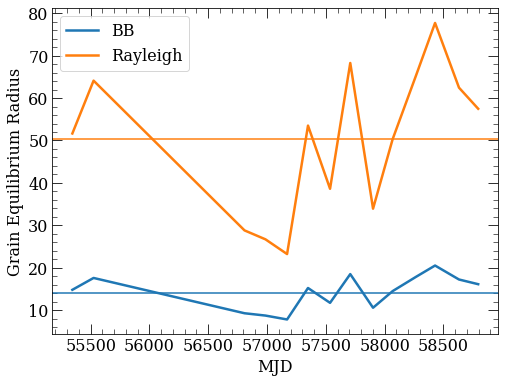

In [414]:
Rstar = 0.2
Tstar = 6500

Rins = Rin_bb(T, Rstar, Tstar)
plt.plot(mjd, Rins, lw = 2.5, label = 'BB')
apo = np.max(Rins)
peri = np.min(Rins)
a = (apo + peri)/2
b = np.sqrt(apo * peri)
e = np.sqrt(1 - (b**2 / a**2))
print(e)
plt.axhline(a)

Rins = Rin_rayl(T, Rstar, Tstar)
plt.plot(mjd, Rins, lw = 2.5, label = 'Rayleigh')
apo = np.max(Rins)
peri = np.min(Rins)
a = (apo + peri)/2
b = np.sqrt(apo * peri)
e = np.sqrt(1 - (b**2 / a**2))
print(e)
plt.axhline(a, color = 'C1')


plt.xlabel("MJD")
plt.ylabel("Grain Equilibrium Radius")

plt.legend()

### MHAOV Periodogram

<ErrorbarContainer object of 3 artists>

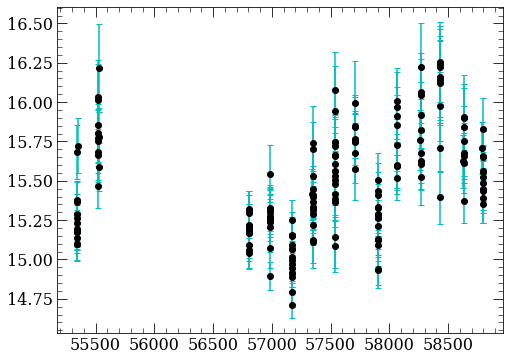

In [24]:
plt.errorbar(mjd, mags, yerr = e_mags,
            linestyle = 'none', marker = 'o', color = 'k', capsize = 3, ecolor = 'c')

In [25]:
my_per = P4J.periodogram(method = 'MHAOV')

my_per.set_data(mjd, mags, e_mags, Nharmonics = 1)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=1.0, fresolution=1e-5)
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=5)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies()

pbest_data = pbest[0]

print(fbest)
print(1 / fbest)

[0.14661 0.1521  0.14112 0.20211 0.19662]
[6.820817  6.574622  7.086168  4.9478006 5.0859528]


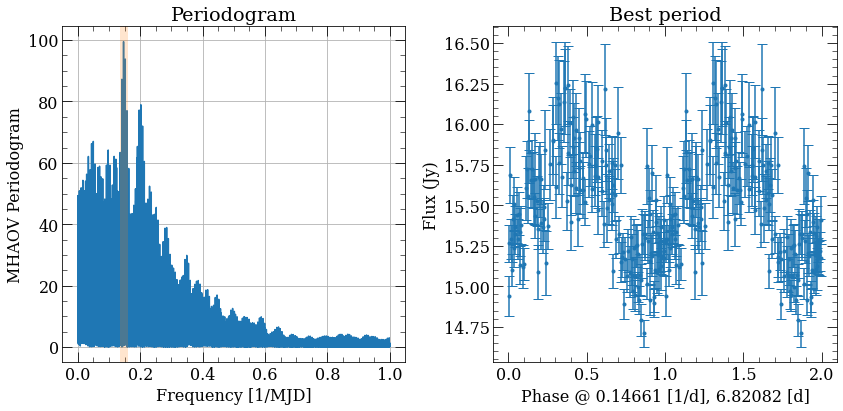

In [26]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('MHAOV Periodogram')
plt.title('Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([mags[idx], mags[idx]]),
            np.concatenate([e_mags[idx], e_mags[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Flux (Jy)')
plt.tight_layout();

In [27]:
period = 1 / fbest[0]

### Phase-Folded Plot

In [42]:
sortt = np.argsort(mjd)

t = mjd[sortt]
flux = np.array([fitsed.mag_to_flux([m])[0] for m in mags])[sortt]
e_flux = (flux * e_mags)[sortt]

In [79]:
nbin = 50
t0 = -0.5

In [86]:
tlc = lk.LightCurve(time = t, flux = mjd)

lc1 = lk.LightCurve(time = t, flux = flux * 100000, flux_err = e_flux * 100000)
phase1 = lc1.fold(period = period, epoch_time = t0, normalize_phase = True).phase.value
p_flux1 = lc1.fold(period = period, epoch_time = t0, normalize_phase = True).flux.value #- stellar_flux[0]
e_p_flux1= lc1.fold(period = period, epoch_time = t0, normalize_phase = True).flux_err.value
raw_phase1 = lc1.fold(period = period, epoch_time = t0, normalize_phase = True).phase.value
raw_flux1 = lc1.fold(period = period, epoch_time = t0, normalize_phase = True).flux.value #- stellar_flux[0]
raw_time1 = tlc.fold(period = period, epoch_time = t0, normalize_phase = True).flux.value

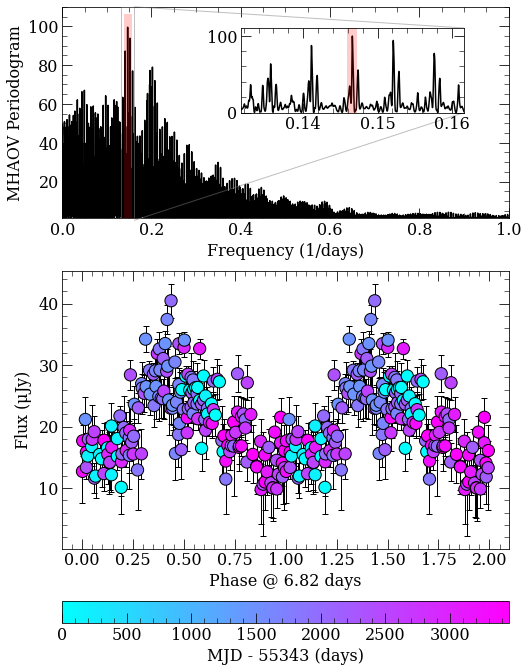

In [96]:
kwargs = dict(linestyle = 'none', marker = 'o', ecolor = 'k', color = 'dodgerblue', capsize = 1, elinewidth = 1,
             mec = 'k', mew = 1.5, markersize = 12)

###### PANEL 1 #########

f = plt.figure(figsize = (8, 12))
gs = f.add_gridspec(8, 1)

ax1 = f.add_subplot(gs[0:3, :])
ax1.plot(freq, per, color = 'k')
ymin, ymax = ax1.get_ylim()
ax1.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2, color = 'r')
ax1.set_ylim([ymin, ymax])
ax1.set_xlabel('Frequency (1/days)')
ax1.set_ylabel('MHAOV Periodogram')
ax1.set_xlim(0, 1)
ax1.set_ylim(1, 110)

tgap = 0.015
ax = ax1
axins = ax.inset_axes([0.4, 0.5, 0.5, 0.4])
axins.plot(freq, per, color = 'k')
# sub region of the original image
x1, x2, y1, y2 = fbest[0] - tgap, fbest[0] + tgap, 0, 110
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.set_xticklabels('')
# axins.set_yticklabels('')
ax.indicate_inset_zoom(axins)
axins.plot([fbest[0], fbest[0]], [y1, y2], linewidth=10, alpha=0.2, color = 'r')

ax2 = f.add_subplot(gs[3:, :])

ax2.errorbar(
    np.concatenate((phase1, phase1 + 1)) + 0.5, 
    np.concatenate((p_flux1, p_flux1)), 
    yerr = np.concatenate((e_p_flux1, e_p_flux1)), 
    ecolor = 'k', capsize = 3, linestyle = 'none', elinewidth = 1
)

scatter = ax2.scatter(
    np.concatenate((raw_phase1, raw_phase1 + 1)) + 0.5, 
    np.concatenate((raw_flux1, raw_flux1)), 
    s = 150, zorder = 100, alpha = 1, c = np.concatenate((raw_time1, raw_time1)) - np.min(raw_time1),
     cmap = 'cool',
    edgecolor = 'k', linewidth = 1
)

ax2.set_ylabel('Flux ($\mu$Jy)')
#ax2.set_ylim(6, 40)
#ax2.set_xlim(-0.1, 2.1)
ax2.set_xlabel('Phase @ %.2f days' % period)

cbar = f.colorbar(scatter, orientation = 'horizontal', pad = 0.135)
cbar.ax.set_xlabel('MJD - %i (days)' % np.min(raw_time1))

plt.subplots_adjust(wspace = 1.5, hspace = 1.5)

plt.savefig('fig/phase_folded.pdf', bbox_inches = 'tight')

## WISE Astrometry

In [99]:
# Nearby source ID: 1798008657411784064

81
178
81


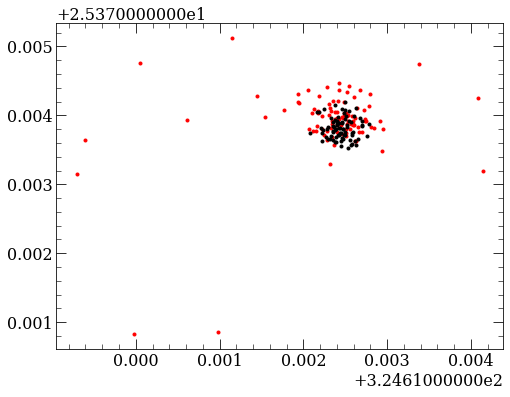

In [100]:
import pandas as pd
from ltsfit.lts_linefit import lts_linefit

wise = pd.read_csv('wise_data/d62_neowise_R.csv')

clean = (
    (wise['sigra'] < 0.5)&
    (wise['sigdec'] < 0.5)&
    (wise['dec'] > 25.3735) &
    (wise['dec'] < 25.3742) & 
    (wise['ra'] < 324.6128)

)

# for nearby:

# clean = (
#     (wise['sigra'] < 0.7)&
#     (wise['sigdec'] < 0.7)&
#     (wise['dec'] > 25.3735) & 
#     (wise['ra'] < 324.6128) &
#     (wise['dec'] > 25.37857)

# )
print(np.sum(clean))
print(len(wise))

plt.plot(wise['ra'][~clean], wise['dec'][~clean], 'r.')
plt.plot(wise['ra'][clean], wise['dec'][clean], 'k.')

wise = wise[clean]
print(len(wise))

In [101]:
allwise_ra = allwise['ra'][0]
allwise_dec = allwise['dec'][0]

In [102]:
allwise_ra

324.6123064

In [103]:
def arrowplot(axes, x, y, narrs=30, dspace=0.5, direc='pos', \
                          hl=0.3, hw=6, fc='black', ec = 'black'): 
    ''' narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head 

        hw     :  width of the arrow head        

        c      :  color of the edge and face of the arrow head  
    '''

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1] 
        dy = y[i]-y[i-1] 
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc is 'neg':
        dspace = -1.*abs(dspace) 
    else:
        dspace = abs(dspace)

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1 
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2. + ax
        dy0 = np.cos(theta)*hl/2. + ay
        dx1 = -1.*np.sin(theta)*hl/2. + ax
        dy1 = -1.*np.cos(theta)*hl/2. + ay

        if direc is 'neg' :
          ax0 = dx0 
          ay0 = dy0
          ax1 = dx1
          ay1 = dy1 
        else:
          ax0 = dx1 
          ay0 = dy1
          ax1 = dx0
          ay1 = dy0 

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, frac=1., ec=ec, fc=fc), zorder = 0)


    axes.plot(x,y, color = ec, zorder = 0)
    axes.set_xlim(x.min()*.9,x.max()*1.1)
    axes.set_ylim(y.min()*.9,y.max()*1.1)

<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-103-f08a574aebce>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direc is 'neg':
<ipython-input-103-f08a574aebce>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direc is 'neg' :


In [104]:
ara = ((allwise_ra)* u.degree).to(u.milliarcsecond).value
adec = ((allwise_dec)* u.degree).to(u.milliarcsecond).value

sig_int:     0.0000      0.4998
Computing sig_int
sig_int:     0.0000      0.4998
sig_int:   584.2388     -0.5628
sig_int:   274.8101     -0.0320
sig_int:   258.2753      0.0084
sig_int:   261.7046     -0.0001
sig_int:   261.5738      0.0002
Computing sig_int error
sig_int:   261.7046      0.1600
sig_int:   584.2388     -0.4026
sig_int:   353.4478      0.0037
sig_int:   355.6232     -0.0011
sig_int:   355.1182     -0.0000
sig_int:   354.9406      0.0004
Repeat at best fitting solution
sig_int:   261.7046     -0.0001
################# Values and formal errors ################
 intercept:  470. +/- 51.
     slope:  92. +/- 33.
   scatter:  262. +/- 93.
Observed rms scatter: 4.7e+02
y = a + b*(x - pivot) with pivot = 1.471
Spearman r=0.31 and p=0.0055
Pearson r=0.28 and p=0.01
##########################################################
seconds 5.32
92.3557382163641 marcsec / yr


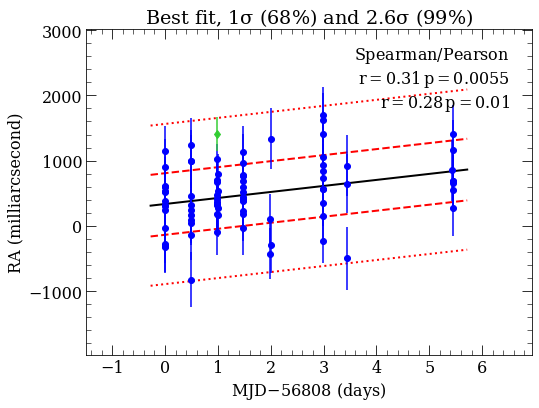

In [105]:
x = (np.array(wise['mjd'] - np.min(wise['mjd'])) * u.day).to(u.year).value
y = (np.array(wise['ra']) * u.degree).to(u.milliarcsecond).value

y = y - ara

e_x = (np.array(np.repeat(0, len(x))) * u.day).to(u.year).value
e_y = (np.array(wise['sigra']) * u.arcsecond).to(u.milliarcsecond).value

plt.clf()
p = lts_linefit(x, y, e_x, e_y, pivot = np.median(x), text = False)
plt.xlabel('MJD$-%i$ (days)' % wise['mjd'].min())
plt.ylabel('RA (milliarcsecond)')
xgap = 1.5
plt.xlim(x.min() - xgap, x.max() + xgap)
ygap = 2500
plt.ylim(np.median(y) - ygap, np.median(y) + ygap)
delta_deg = p.ab[1] * u.milliarcsecond / u.year ## degrees per day

print(delta_deg)

pra = p.ab
e_pra = p.ab_err

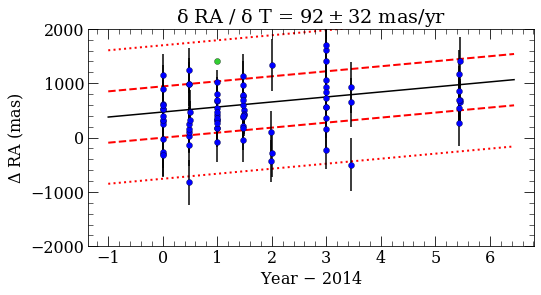

In [106]:
plt.figure(figsize = (8, 4))

plt.errorbar(x[p.mask], y[p.mask], xerr = e_x[p.mask], yerr = e_y[p.mask], mfc = 'blue', 
             linestyle = 'none', 
                mec = 'k', mew = 0.3, marker = 'o', ecolor = 'k', capsize = 0)

plt.errorbar(x[~p.mask], y[~p.mask], color = 'LimeGreen', 
             linestyle = 'none', 
            mec = 'k', mew = 0.3, marker = 'o')

xmin, xmax = x.min(), x.max()
xgap = 1
xlimits = np.linspace(xmin - xgap, xmax + xgap)

plt.plot(xlimits, p.ab[0] + p.ab[1] * xlimits, 'k')

plt.plot(xlimits, p.rms + p.ab[0] + p.ab[1] * xlimits, 'r--',
         xlimits, p.ab[0] + p.ab[1] * xlimits - p.rms, 'r--',
        xlimits, 2.6*p.rms + p.ab[0] + p.ab[1] * xlimits, 'r:',
        xlimits, p.ab[0] + p.ab[1] * xlimits - 2.6*p.rms, 'r:',
        lw = 2, zorder = 1)

plt.ylim(-2000, 2000)
plt.xlabel('Year $-$ 2014')
plt.ylabel('$\Delta$ RA (mas)')
plt.title('$\delta$ RA / $\delta$ T = $%i \pm %i$ mas/yr' % (p.ab[1], p.ab_err[1]))

plt.savefig('fig/wise_pmra.pdf', bbox_inches = 'tight')

sig_int:     0.0000     -0.1478
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.1478
################# Values and formal errors ################
 intercept:  1244. +/- 41.
     slope:  253. +/- 27.
   scatter:  0. +/- 0.0
Observed rms scatter: 3.5e+02
y = a + b*(x - pivot) with pivot = 1.471
Spearman r=0.66 and p=1.4e-11
Pearson r=0.72 and p=3.8e-14
##########################################################
seconds 0.80
253.01157794322137 marcsec / yr


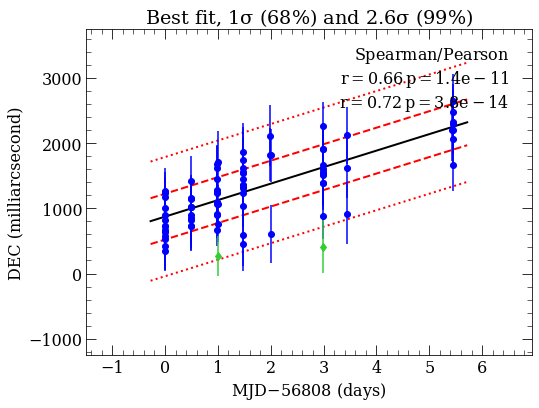

In [107]:
x = (np.array(wise['mjd'] - np.min(wise['mjd'])) * u.day).to(u.year).value
y = (np.array(wise['dec']) * u.degree).to(u.milliarcsecond).value

y = y - adec

e_x = (np.array(np.repeat(0, len(x))) * u.day).to(u.year).value
e_y = (np.array(wise['sigdec']) * u.arcsecond).to(u.milliarcsecond).value

plt.clf()
p = lts_linefit(x, y, e_x, e_y, pivot = np.median(x), text = False)
plt.xlabel('MJD$-%i$ (days)' % wise['mjd'].min())
plt.ylabel('DEC (milliarcsecond)')
xgap = 1.5
plt.xlim(x.min() - xgap, x.max() + xgap)
ygap = 2500
plt.ylim(np.median(y) - ygap, np.median(y) + ygap)
delta_deg = p.ab[1] * u.milliarcsecond / u.year ## degrees per day

print(delta_deg)
pdec = p.ab
e_pdec = p.ab_err

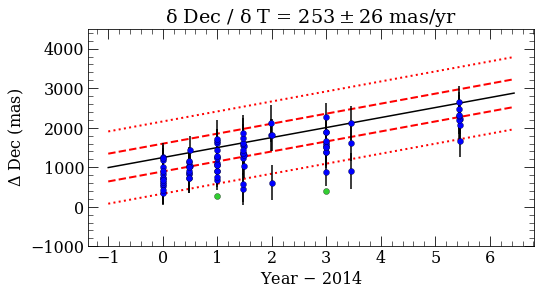

In [108]:
plt.figure(figsize = (8, 4))

plt.errorbar(x[p.mask], y[p.mask], xerr = e_x[p.mask], yerr = e_y[p.mask], mfc = 'blue', 
             linestyle = 'none', 
                mec = 'k', mew = 0.3, marker = 'o', ecolor = 'k', capsize = 0)

plt.errorbar(x[~p.mask], y[~p.mask], color = 'LimeGreen', 
             linestyle = 'none', 
            mec = 'k', mew = 0.3, marker = 'o')

xmin, xmax = x.min(), x.max()
xgap = 1
xlimits = np.linspace(xmin - xgap, xmax + xgap)

plt.plot(xlimits, p.ab[0] + p.ab[1] * xlimits, 'k')

plt.plot(xlimits, p.rms + p.ab[0] + p.ab[1] * xlimits, 'r--',
         xlimits, p.ab[0] + p.ab[1] * xlimits - p.rms, 'r--',
        xlimits, 2.6*p.rms + p.ab[0] + p.ab[1] * xlimits, 'r:',
        xlimits, p.ab[0] + p.ab[1] * xlimits - 2.6*p.rms, 'r:',
        lw = 2, zorder = 1)

plt.ylim(-1000, 4500)
plt.xlabel('Year $-$ 2014')
plt.ylabel('$\Delta$ Dec (mas)')
plt.title('$\delta$ Dec / $\delta$ T = $%i \pm %i$ mas/yr' % (p.ab[1], p.ab_err[1]));

plt.savefig('fig/wise_pmdec.pdf', bbox_inches = 'tight')

In [109]:
import matplotlib
cmap = matplotlib.cm.get_cmap('cool')

<ipython-input-110-e8fbf0d71a41>:58: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
  plt.savefig('fig/wise_radec.pdf', bbox_inches = 'tight')
<ipython-input-110-e8fbf0d71a41>:58: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
  plt.savefig('fig/wise_radec.pdf', bbox_inches = 'tight')
/Users/vedantchandra/opt/anaconda3/envs/d62/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
  fig.canvas.print_figure(bytes_io, **kw)


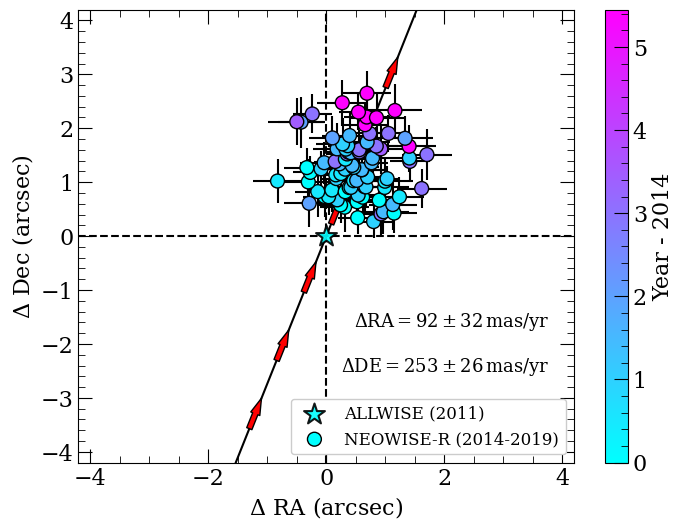

In [110]:
plt.figure(figsize = (8, 6), dpi = 100)

ara = ((allwise_ra)* u.degree).to(u.milliarcsecond).value
adec = ((allwise_dec)* u.degree).to(u.milliarcsecond).value

t = (np.array(wise['mjd']) - np.min(np.array(wise['mjd']))) / 365

x = (np.array(wise['ra']) * u.degree).to(u.milliarcsecond).value
x = x - ara
e_x = (np.array(wise['sigra']) * u.arcsecond).to(u.milliarcsecond).value

y = (np.array(wise['dec']) * u.degree).to(u.milliarcsecond).value
y = y - adec
e_y = (np.array(wise['sigdec']) * u.arcsecond).to(u.milliarcsecond).value

plt.scatter(0, 0,
            marker = '*', edgecolor = 'k', s = 250, linewidth = 1.5, 
               color = cmap(0), label = 'ALLWISE (2011)', alpha = 0.9)

plt.scatter(x/1000, y/1000, c = t, cmap = 'cool',
            marker = 'o', edgecolor = 'k', linewidth = 1, s = 100, label = 'NEOWISE-R (2014-2019)',
            alpha = 1
           )

plt.errorbar(x/1000, y/1000, xerr = e_x/1000, yerr = e_y/1000, linestyle = 'none',
             capsize = 0, zorder = 0, color = 'k'
)
plt.axvline(0, color = 'k', linestyle = '--', zorder = 0)
plt.axhline(0, color = 'k', linestyle = '--', zorder = 0)


cbar = plt.colorbar()
cbar.ax.set_ylabel('Year - 2014')
plt.xlabel('$\Delta$ RA (arcsec)')
plt.ylabel('$\Delta$ Dec (arcsec)')

tgrid = np.linspace(-25, 25)
ragrid = tgrid * pra[1] + 0
decgrid = tgrid * pdec[1] + 0

ax = plt.gca()

arrowplot(ax, ragrid/1000, decgrid/1000, direc = 'neg', hl = 0.6, hw = 7, 
          narrs = 10, dspace = 0.6, ec = 'black', fc = 'red')

plt.ylim(-4.2, 4.2)
plt.xlim(-4.2, 4.2)

plt.text(0.95, 0.3, '$\Delta{RA} = %i \pm %i\, mas/yr$' % (pra[1], e_pra[1]), 
         transform = ax.transAxes, ha = 'right', fontsize = 13)
plt.text(0.95, 0.2, '$\Delta{DE} = %i \pm %i\, mas/yr$' % (pdec[1], e_pdec[1]), 
         transform = ax.transAxes, ha = 'right', fontsize = 13)

#plt.plot(ragrid, decgrid, zorder = 10, color = 'r', linestyle = '--')

plt.legend(fontsize = 12, framealpha = 1, loc = 'lower right')

plt.savefig('fig/wise_radec.pdf', bbox_inches = 'tight')

In [111]:
pra[1]

92.3557382163641

In [112]:
pra[1] * np.cos(wise['dec'].median() * np.pi / 180)

83.44630068553607

In [113]:
wise['dec'].median()

25.3738047

## Jura Inner Temperature Variation (WIP)

In [119]:
from astropy import constants as c
import astropy.units as u
from scipy import integrate

In [120]:
def jura_disk(wl, D, i, T_star, R_star, T_in, T_out):
    
    nu = c.c / (wl * 1e-10 * u.m)
    R_star = R_star * c.R_sun
    D = D * c.pc
    T_star = T_star * u.K
    T_in = T_in * u.K
    T_out = T_out * u.K
    
    t1 = 12 * np.pi**(1/3) * R_star**2 * np.cos(i * np.pi / 180) / D**2
    t2 = (2 * c.k_B * T_star / (3 * c.h * nu)) ** (8 / 3)
    t3 = c.h * nu**3 / c.c**2
    
    xmin = c.h * nu / (c.k_B * T_in)
    xmax = c.h * nu / (c.k_B * T_out)

    fn = lambda x: x**(5/3) / (np.exp(x) - 1)
    t4 = integrate.quad(fn, xmin.value, xmax.value)[0]
    
        
    return (t1*t2*t3*t4).to(u.Jy).value

def disk_model(wl, D, i, T_star, R_star, T_in, T_out):
    return np.array([jura_disk(wli, D, i, T_star, R_star, T_in, T_out) for wli in wl]) #* u.Jy

In [146]:
bestfit = [6.38875443e+03, 2.16610353e-01, 1.19353605e+00] # copy from SED notebook
stellar_flux = [8.76175000e-05, 5.03066244e-05] # in Jy, copy from SED notebook

wls = [33680, 46180]

D = 1000 / bestfit[2]
i = 0
R_star = bestfit[1]
T_star = bestfit[0]

T_out = 250 # FIXED


def fit_disk(T_in, flux):
    resid = flux - disk_model(wls, D, i, T_star, R_star, T_in, T_out)
    return np.sum(resid**2)

In [154]:
t = mjd[sortt]
flux = np.array([fitsed.mag_to_flux([m])[0] for m in mags])[sortt]
e_flux = (flux * e_mags)[sortt]

flux2 = np.array([fitsed.mag_to_flux([m])[0] for m in mags2])[sortt]
e_flux2 = (flux2 * e_mags2)[sortt]

In [156]:
lc1 = lk.LightCurve(time = t, flux = flux, flux_err = e_flux)

lc2 = lk.LightCurve(time = t, flux = flux2, flux_err = e_flux2)

In [191]:
phase1 = lc1.fold(period = period, epoch_time = t0).bin(bins = 10).phase.value #+ 0.5
p_flux1 = lc1.fold(period = period, epoch_time = t0).bin(bins = 10).flux.value - stellar_flux[0]
e_p_flux1= lc1.fold(period = period, epoch_time = t0).bin(bins = 10).flux_err.value

phase2 = lc2.fold(period = period, epoch_time = t0).bin(bins = 10).phase.value #+ 0.5
p_flux2 = lc2.fold(period = period, epoch_time = t0).bin(bins = 10).flux.value - stellar_flux[1]
e_p_flux2= lc2.fold(period = period, epoch_time = t0).bin(bins = 10).flux_err.value

phase1 = (phase1 - phase1.min()) / (phase1.max() - phase1.min())

theta = 2 * np.pi * phase1

In [240]:
p0 = [1000]

temps = [];
e_temps = [];

nmc = 50

for ii in tqdm(range(len(p_flux1))):
    temp_samples = [];
    for kk in range(nmc):
        
        fl1 = p_flux1[ii] + e_p_flux1[ii] * np.random.normal()
        fl2 = p_flux2[ii] + e_p_flux2[ii] * np.random.normal()
        
        obs_flux = np.array([fl1, fl2])
    
        res = scipy.optimize.minimize(fit_disk, args = (obs_flux), x0 = p0, method = 'Nelder-Mead')
        temp_samples.append(res.x[0])
    
    temps.append(np.mean(temp_samples))
    e_temps.append(np.std(temp_samples))

temps = np.array(temps)
e_temps = np.array(e_temps)

100%|██████████| 10/10 [00:50<00:00,  5.02s/it]


(array([1., 0., 4., 0., 1., 3., 3., 1., 2., 1., 3., 2., 7., 2., 2., 3., 4.,
        3., 3., 1., 2., 0., 0., 1., 1.]),
 array([ 981.49023056,  999.83584595, 1018.18146133, 1036.52707672,
        1054.87269211, 1073.2183075 , 1091.56392288, 1109.90953827,
        1128.25515366, 1146.60076904, 1164.94638443, 1183.29199982,
        1201.6376152 , 1219.98323059, 1238.32884598, 1256.67446136,
        1275.02007675, 1293.36569214, 1311.71130753, 1330.05692291,
        1348.4025383 , 1366.74815369, 1385.09376907, 1403.43938446,
        1421.78499985, 1440.13061523]),
 <BarContainer object of 25 artists>)

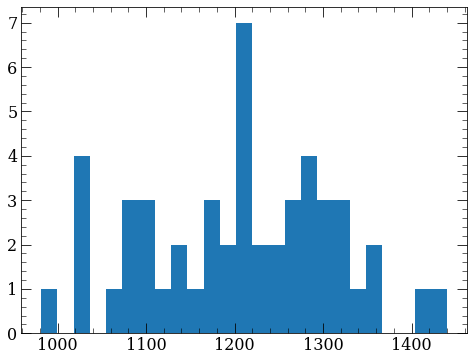

In [241]:
plt.hist(temp_samples)

Text(0.5, 0, 'Phase')

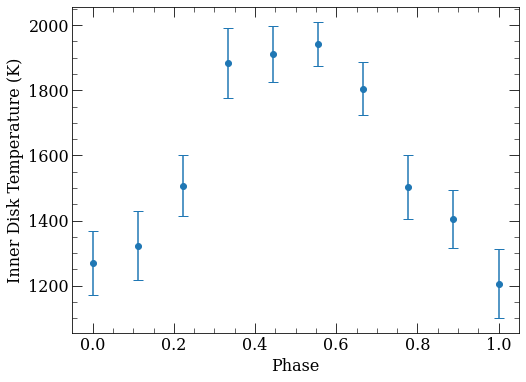

In [242]:
plt.errorbar(phase1, temps, yerr = e_temps, linestyle = "none", marker = 'o')
plt.ylabel('Inner Disk Temperature (K)')
plt.xlabel('Phase')

In [243]:
R_bb = R_star/2 * (T_star / temps)**2
e_R_bb = (e_temps / temps) * R_bb

In [244]:
def r_kep(theta, a, e, shift):
    return a * (1 - e**2) / (1 + e * np.cos(theta - shift))

p0 = [2.5, 0.5, 2.7]

In [245]:
p, cov = scipy.optimize.curve_fit(r_kep, theta, R_bb, p0 = [4, 0.5, 1],
                                 bounds = ([0, 0, 0], [10, 2, 6]))

print(p)

[2.02708559 0.41804193 3.20653101]


Text(0, 0.5, 'Radius')

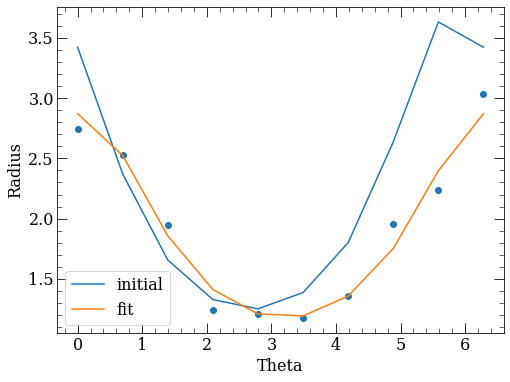

In [246]:
plt.scatter(theta, R_bb)
plt.plot(theta, r_kep(theta, *p0), label = 'initial')
plt.plot(theta, r_kep(theta, *p), label = 'fit')

plt.legend()

plt.xlabel('Theta')
plt.ylabel('Radius')

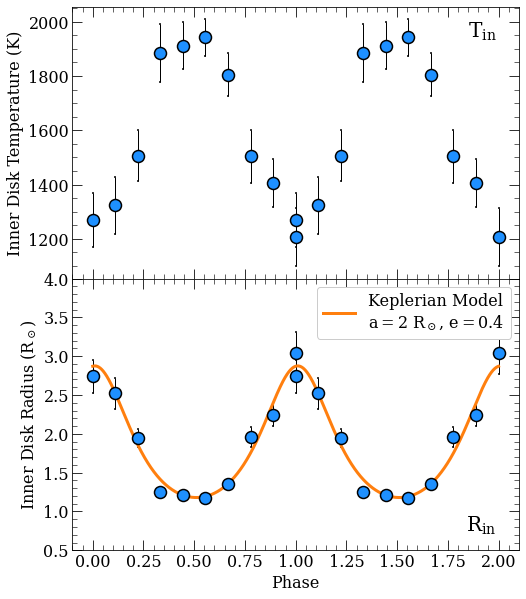

In [249]:
plt.figure(figsize = (8,10))

tgrid = np.linspace(theta.min(), theta.max(), 1000)
pgrid =  np.linspace(phase1.min(), phase1.max(), 1000)

ax = plt.subplot(211)

plt.errorbar(
    np.concatenate((phase1, phase1 + 1)), 
    np.concatenate((temps, temps)), 
    yerr = np.concatenate((e_temps, e_temps)), 
    **kwargs)

plt.ylabel('Inner Disk Temperature (K)')
plt.gca().set_xticklabels([])
ax.text(0.95, 0.95, '$T_{in}$', transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)

ax = plt.subplot(212)

plt.errorbar(
    np.concatenate((phase1, phase1 + 1)), 
    np.concatenate((R_bb, R_bb)), 
    yerr = np.concatenate((e_R_bb, e_R_bb)), 
    **kwargs)


plt.plot(
    np.concatenate((pgrid, pgrid + 1)), 
    np.concatenate((r_kep(tgrid, *p), r_kep(tgrid, *p))),
    color = 'C1', 
    label = 'Keplerian Model\n$a = %i\ R_\odot$, $e = %.1f$' %(p[0],p[1]), lw = 3
)

plt.xlabel('Phase')
plt.ylabel('Inner Disk Radius ($R_\odot$)')
ax.text(0.95, 0.05, '$R_{in}$', transform = ax.transAxes, ha = 'right', va = 'bottom', fontsize = 20)

plt.legend(framealpha = 1, loc = 'upper right')
plt.subplots_adjust(wspace = 0, hspace = 0)

plt.ylim(0.5, 4)

plt.savefig('fig/keplerian_radius.pdf', bbox_inches = 'tight')

In [250]:
rp = a*(1 - e)
print(rp)

1.125
